<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_PyTorch/blob/main/17AlexNetKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

In [2]:
# training batches of our network
EPOCHS = 3
# size of each batch
BATCH_SIZE = 100

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(DEVICE)

2.9.0+cpu
cpu


In [3]:
train_csv = pd.read_csv('/content/fashion-mnist_train.csv')
test_csv = pd.read_csv('/content/fashion-mnist_test.csv')


print(train_csv.shape)
print(test_csv.shape)

# Customize training size here
inputSize = 8000
train_csv=train_csv[:inputSize]
len(train_csv)


(60000, 785)
(10000, 785)


8000

In [4]:
print(train_csv.info())
print(train_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 47.9 MB
None
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0       

The FashionDataset class is a custom dataset class for handling the Fashion MNIST data with PyTorch. It inherits from torch.utils.data.Dataset, which is a base class that provides an interface for custom datasets.

Here's a breakdown of its methods:

__init__(self, data, transform=None):

This is the constructor method, called when you create an instance of FashionDataset.
It takes data (which is expected to be a pandas DataFrame containing the dataset) and an optional transform function (for image preprocessing).
It converts the input DataFrame data into a list of values (self.fashion_MNIST).
It separates the labels (first column of the DataFrame) and the image pixel data (remaining columns).
The image data is then reshaped into a 28x28 grayscale image format and converted to float32.
self.labels stores the class labels, and self.images stores the processed image data.
__len__(self):

This method returns the total number of samples (images) in the dataset.
It's essential for PyTorch's DataLoader to know the size of the dataset.
__getitem__(self, idx):

This method is crucial for retrieving individual samples from the dataset given an idx (index).
It fetches the label and image corresponding to the given index.
If a transform function was provided during initialization, it first converts the numpy image array to a PIL Image (as many torchvision.transforms operate on PIL Images) and then applies the transformation.
Finally, it returns the processed image and its label.

The FashionDataset class is a custom dataset class designed to work with the Fashion MNIST data using PyTorch. It inherits from torch.utils.data.Dataset, providing a structured way to handle your data.

Here's a step-by-step breakdown of its key components:

__init__(self, data, transform=None):
This is the constructor method, called when you create an instance of FashionDataset. It initializes the dataset with the provided data and an optional transformation.

self.fashion_MNIST = list(data.values): It takes the input data (expected to be a pandas DataFrame) and converts its values into a list. This list will contain rows where the first element is the label and the rest are pixel values.
self.transform = transform: It stores any image transformation function (like resizing, normalization) that you want to apply to the images.
Separating Labels and Images: It iterates through self.fashion_MNIST to:
Extract the first element of each row as the label.
Extract the remaining elements of each row as image pixel data.
self.labels = np.asarray(label): Converts the collected label list into a NumPy array, which stores all the class labels for the dataset.
self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32'): Converts the collected image pixel data into a NumPy array. It then reshapes each image into a 28x28 format (assuming a single channel for grayscale images) and casts the data type to float32, which is common for neural network inputs.
__len__(self):
This method is crucial for PyTorch's DataLoader and simply returns the total number of samples (images) in your dataset. It's implemented as return len(self.images).

__getitem__(self, idx):
This method is called by the DataLoader to retrieve a single sample from the dataset at a given idx (index).

label = self.labels[idx]: It fetches the true class label corresponding to the given index.
image = self.images[idx]: It fetches the raw image data (the 28x28 NumPy array) corresponding to the given index.
Applying Transformations (if any):
if self.transform is not None:: Checks if a transformation function was provided during initialization.
pil_image = Image.fromarray(np.uint8(image)): If a transform exists, it first converts the NumPy image array into a PIL (Pillow) Image object. Many torchvision.transforms are designed to operate on PIL Images.
image = self.transform(pil_image): The transformation function (e.g., AlexTransform as defined later in your notebook) is then applied to the PIL Image.
return image, label: Finally, it returns the processed image (as a PyTorch tensor after transformations) and its corresponding label.

In [5]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform

        label, image = [], []

        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image))
            image = self.transform(pil_image)

        return image, label

transforms.Compose([...]): This is a utility class from torchvision that allows you to combine several transform operations into a single callable transform. The transformations inside the list are applied sequentially.

transforms.Resize((227, 227)):

This transformation resizes the input image to a specified size, in this case, 227x227 pixels.
Fashion MNIST images are originally 28x28 pixels. AlexNet, which this transformation is likely preparing data for, typically expects larger input images (like 227x227 or 224x224), so this step scales up the images.
transforms.ToTensor():

This converts a PIL Image or NumPy ndarray into a PyTorch FloatTensor.
It also scales the pixel intensity values from the range [0, 255] to [0.0, 1.0]. This normalization is important for neural networks as it helps with training stability and performance.
transforms.Normalize((0.1307,), (0.3081,)):

This normalizes a tensor image with mean and standard deviation. The formula for normalization is (image - mean) / std.
(0.1307,) is the mean for a single-channel grayscale image (like Fashion MNIST).
(0.3081,) is the standard deviation for a single-channel grayscale image.
This step further normalizes the pixel values to have a mean of 0 and a standard deviation of 1, which can further aid in network training.

In [6]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [7]:
train_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform),
    batch_size=100, shuffle=True)

test_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform),
    batch_size=100, shuffle=True)

The matplotlib_imshow function is a helper function designed to display an image using Matplotlib. Let's break down what it does:

img = img.mean(dim=0): This line calculates the mean along the first dimension (dim=0) of the input image tensor. Since the images in this context are likely grayscale and might have an extra channel dimension (e.g., [1, height, width]), this step effectively removes that channel dimension, reducing it to [height, width] for a single-channel image.

img = img / 2 + 0.5: This step is for unnormalizing the image. Often, images are normalized to a range like [-1, 1] or [0, 1] for model training. If the original normalization was (img - mean) / std, then to get back to a [0, 1] range (which matplotlib.pyplot.imshow expects for displaying images), you would perform an inverse operation. In this specific case, it seems the images were normalized such that 0 becomes -1 and 1 becomes 1. Dividing by 2 and adding 0.5 transforms values from [-1, 1] back to [0, 1].

npimg = img.numpy(): This converts the PyTorch tensor img into a NumPy array npimg. Matplotlib's imshow function typically works with NumPy arrays.

plt.imshow(npimg, cmap="Greys"): This is the core Matplotlib call. It displays the NumPy array npimg as an image. The cmap="Greys" argument specifies that the image should be displayed using a grayscale color map, which is appropriate for the Fashion MNIST images.

In essence, this function takes a normalized PyTorch image tensor, unnormalizes it, converts it to a NumPy array, and then displays it as a grayscale image.

------------------------------------------

images: From the previous lines of code:

dataiter = iter(train_loader)
images, labels = next(dataiter)
images is a batch of images obtained from the train_loader. Since your BATCH_SIZE is 100, images is a PyTorch tensor containing 100 transformed images. Its shape would typically be [BATCH_SIZE, C, H, W], e.g., [100, 1, 227, 227] after your AlexTransform.

images[0]: This selects the first image from the images batch. So, images[0] is a single image tensor with a shape like [C, H, W] (e.g., [1, 227, 227] for a single-channel image).

torchvision.utils.make_grid(): This function is designed to take a batch of images (a 4D tensor of shape (N, C, H, W)) or a list of individual image tensors (each of shape (C, H, W)) and arrange them into a single grid image. While it's typically used to visualize multiple images together, it can also process a single image.

When given a single 3D image tensor like images[0], make_grid essentially treats it as a batch of one image. It formats this single image, possibly adding a small amount of padding around it by default, and returns a new 3D tensor representing that image, now ready for display (e.g., by matplotlib_imshow).
In essence, this line takes the very first image from your training batch, formats it using make_grid (which, for a single image, mostly just ensures it's in a displayable format and adds a subtle border), and assigns the resulting single-image tensor to img_grid.

Sneaker


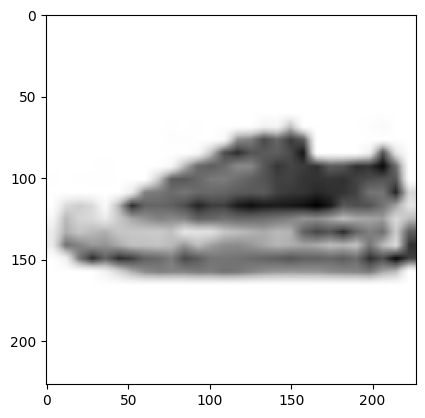

In [8]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [9]:
class fasion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [10]:
model = fasion_mnist_alexnet().to(DEVICE)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())
error = nn.CrossEntropyLoss()

In [11]:
loss_list_train=[]
loss_list_val=[]
accuracy_train=[]


def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        accuracy_train.append((batch_idx / len(train_loader))*100)
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

pred = output.max(1, keepdim=True)[1]:

output: This tensor contains the raw predictions (logits or log-probabilities) from your neural network for each image in the current batch. It typically has a shape like [batch_size, num_classes] (e.g., [100, 10] for a batch of 100 images and 10 classes).
.max(1, keepdim=True): This function finds the maximum value along a specified dimension (here, dim=1, which corresponds to the num_classes dimension). It returns a tuple containing two tensors: the maximum values themselves, and the indices (positions) where those maximum values occurred.
keepdim=True: Ensures that the output tensor retains the same number of dimensions as the input. So, if output was [100, 10], the result would be ([100, 1], [100, 1]).
[1]: We are interested in the indices of the maximum values, which represent the predicted class for each image. By using [1], we select the second element of the tuple, which is the tensor of predicted class indices. So, pred will be a tensor of shape [batch_size, 1] (e.g., [100, 1]) containing the predicted class label for each image in the batch.
correct += pred.eq(target.view_as(pred)).sum().item():

target: This tensor holds the true (ground truth) class labels for each image in the current batch. It typically has a shape like [batch_size] (e.g., [100]).
target.view_as(pred): This reshapes the target tensor to match the shape of the pred tensor. Since pred is [batch_size, 1], target is also reshaped to [batch_size, 1]. This is crucial for performing element-wise comparison.
pred.eq(...): This performs an element-wise equality comparison between the predicted labels (pred) and the true labels (target.view_as(pred)). It returns a new boolean tensor of the same shape, where True indicates a correct prediction and False indicates an incorrect prediction.
.sum(): This sums up all the True values in the boolean tensor. In PyTorch, True is treated as 1 and False as 0, so this effectively counts the number of correct predictions in the current batch.
.item(): This converts the single-element PyTorch tensor (which now holds the count of correct predictions) into a standard Python integer.
correct += ...: Finally, this adds the number of correct predictions from the current batch to the correct variable, which is accumulating the total number of correct predictions across all batches.

In [12]:
accuracy_val=[]
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # loss之和除以data数量 -> mean
        accuracy_val.append(100. * correct / len(test_loader.dataset))
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print(test_loss)
        print(correct)
        print(accuracy_val)
        print('='*50)

In [14]:
train(model, DEVICE, train_loader, optimizer, EPOCHS)

Train Epoch:3 [2900/8000 (36%)]	Loss: 1.083980
Train Epoch:3 [5900/8000 (74%)]	Loss: 0.674653


In [15]:
test(model,DEVICE, test_loader)


Test set: Average loss: 0.6289, Accuracy: 5966/8000 (75%)

0.6289306564331054
5966
[74.575]
